In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt
import smtplib
from datetime import datetime, timedelta
from dateutil.relativedelta import *
from requests_html import HTMLSession
import sys, os
import io
import quandl as quandl 
from hurst import compute_Hc
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import chi2_contingency

In [3]:
final_df = pd.DataFrame()
start_date = '2006-01-01'
end_date = '2020-12-31'
api_string="44ErNV5zLdE6K7QpDWff"

def get_data(stock_code):
    start_time = datetime(2006, 1, 1, 0, 0) 
#     end_time = datetime.today()
    end_time = datetime(2020, 12, 31, 0, 0) 
    day_type = '1d'

    df = yf.download(stock_code,start=start_time,end=end_time,interval=day_type)            
    df = df.fillna(method='ffill')
    return df

# 1) Portfoilo DF

Purpose - To prevent return of more than -10%

Observation 
- When things go south, transfer more assets to US 5Y Treasury Futures (Low Risk, Medium Reward)- 
- Commodity Return is bad - Only have position when you are super confident (High Risk, Low Reward)
- World index - Go in if it is possible (Medium Risk, High Reward)

In [29]:
portfoilo_data = pd.read_excel('DATA INPUTS 2001 - 2021.xlsx')
portfoilo_data = portfoilo_data.set_index('Dates')
portfoilo_data = portfoilo_data.reindex(index=portfoilo_data.index[::-1])

portfoilo_data = portfoilo_data.resample('1m').mean()

portfoilo_data['MSCI World Index %'] = portfoilo_data['MSCI World Index'].pct_change()
portfoilo_data['Goldman Commodity Index %'] = portfoilo_data['Goldman Commodity Index'].pct_change()
portfoilo_data['US 5Y Treasury Futures %'] = portfoilo_data['US 5Y Treasury Futures'].pct_change()
portfoilo_data['Combination Return %'] = portfoilo_data['MSCI World Index %'] * 0.5 + portfoilo_data['Goldman Commodity Index %'] * 0.35 + portfoilo_data['US 5Y Treasury Futures %'] * 0.15

portfoilo_data['MSCI World Index Overall Return'] = portfoilo_data['MSCI World Index'].pct_change().cumsum()
portfoilo_data['Goldman Commodity Index Overall Return'] = portfoilo_data['Goldman Commodity Index'].pct_change().cumsum()
portfoilo_data['US 5Y Treasury Futures Overall Return'] = portfoilo_data['US 5Y Treasury Futures'].pct_change().cumsum()
portfoilo_data['Combination Overall Return'] = portfoilo_data['Combination Return %'].cumsum()

portfoilo_data['Combination Monthly Max Drawdown'] = portfoilo_data['Combination Overall Return'].rolling(30, min_periods=1).min()
portfoilo_data['Combination Monthly Max Drawdown Prediction'] = portfoilo_data['Combination Monthly Max Drawdown'].shift(1)

portfoilo_data = portfoilo_data[(portfoilo_data.index > '2006-01-01') &
                                (portfoilo_data.index < '2020-12-31')]

final_df['MSCI World Index %'] = portfoilo_data['MSCI World Index %']
final_df['Goldman Commodity Index %'] = portfoilo_data['Goldman Commodity Index %']
final_df['US 5Y Treasury Futures %'] = portfoilo_data['US 5Y Treasury Futures %']
final_df['Combination Return %'] = portfoilo_data['Combination Overall Return']
final_df['Combination Max Drawdown Monthly'] = portfoilo_data['Combination Monthly Max Drawdown'] 
final_df['Combination Max Drawdown Prediction'] = portfoilo_data['Combination Monthly Max Drawdown Prediction'] 

portfoilo_figure = px.line(portfoilo_data, x=portfoilo_data.index, y=['MSCI World Index','Goldman Commodity Index','US 5Y Treasury Futures'], title='Portfoilo Value')
portfoilo_figure.update_layout(hovermode="x")
portfoilo_figure.show()

portfoilo_figure2 = px.line(portfoilo_data, x=portfoilo_data.index, y=['Combination Monthly Max Drawdown','Combination Overall Return'], title='Portfoilo Overall Return')
portfoilo_figure2.update_layout(hovermode="x")
portfoilo_figure2.show()

portfoilo_figure3 = px.line(portfoilo_data, x=portfoilo_data.index, y=['MSCI World Index Overall Return','Goldman Commodity Index Overall Return','US 5Y Treasury Futures Overall Return'], title='Portfoilo Overall Return')
portfoilo_figure3.update_layout(hovermode="x")
portfoilo_figure3.show()

portfoilo_figure4 = px.line(portfoilo_data, x=portfoilo_data.index, y=['MSCI World Index %','Goldman Commodity Index %','US 5Y Treasury Futures %','Combination Return %'], title='Portfoilo Monthly Return')
portfoilo_figure4.update_layout(hovermode="x")
portfoilo_figure4.show()

# 2) Risk Indicator

## 2.1) Gold

In [6]:
gold_data = pd.read_csv('XAU_USD Historical Data.csv')
gold_data['Date'] = pd.to_datetime(gold_data['Date'])
gold_data = gold_data.set_index('Date').sort_index()
# gold_data = gold_data.reindex(index=gold_data.index[::-1])
gold_data['Price'] = pd.to_numeric(gold_data['Price'].str.replace(',',''))

gold_data = gold_data.resample('1m').mean()

gold_data['percent change'] = gold_data['Price'].pct_change()
gold_data['Overall Return'] = gold_data['percent change'].cumsum()

final_df['Gold percent change'] = gold_data['percent change'] 
# display(gold_data.head())

gold_figure3 = px.line(gold_data, x=gold_data.index, y="Overall Return", title='Overall Return')
gold_figure3.update_layout(hovermode="x")
gold_figure3.show()

gold_figure4 = px.line(gold_data, x=gold_data.index, y="percent change", title='Monthly Return')
gold_figure4.update_layout(hovermode="x")
gold_figure4.show()


## 2.2) VIX

In [7]:
VIX_data = get_data('^VIX')
VIX_data = VIX_data.resample('1m').mean()
                                  
final_df['VIX'] = VIX_data['Adj Close']

# display(VIX_data.head())
                                      
vix_figure = px.line(VIX_data, x=VIX_data.index, y="Adj Close", title='VIX Value')
vix_figure.update_layout(hovermode="x")
vix_figure.show()


[*********************100%***********************]  1 of 1 completed


## 2.3) 10-Year Treasury Constant Maturity Minus 2-Year Treasury Constant Maturity

https://ycharts.com/indicators/10_2_year_treasury_yield_spread

In [9]:
Treasury_Data = pd.read_excel("T10Y2Y.xls")
Treasury_Data = Treasury_Data.set_index('observation_date')

Treasury_Data = Treasury_Data.resample('1m').mean()

Treasury_Data = Treasury_Data[(Treasury_Data.index > '2006-01-01') &
                              (Treasury_Data.index < '2020-12-31')]

# display(Treasury_Data)

treasury_figure = px.line(Treasury_Data, x=Treasury_Data.index, y=["T10Y2Y"], title='Treasury Value')
treasury_figure.update_layout(hovermode="x")
treasury_figure.show()

final_df['T10Y2Y'] = Treasury_Data['T10Y2Y']

## 2.4)  United States Misery Index

In [10]:
misery_data = quandl.get("USMISERY/INDEX", api_key=api_string, start_date=start_date, end_date=end_date)

In [11]:
misery_data.index = pd.to_datetime(misery_data.index)

# display(misery_data.head())

final_df['Misery Index'] = misery_data['Misery Index']

misery_figure = px.line(misery_data, x=misery_data.index, y="Misery Index", title='Misery Value')
misery_figure.update_layout(hovermode="x")
misery_figure.show()

## 2.5) US High Yield Corporate Bond Index OAS

In [12]:
corporate_data_source = quandl.get("ML/HYOAS", api_key = api_string, start_date=start_date, end_date=end_date)

In [14]:
# The risk-free rate we will use is the one-year Treasury bill rate
# Source: https://fred.stlouisfed.org/series/DGS1
rf = pd.read_excel('DGS1.xls')
rf = rf.set_index('observation_date')
rf = rf[(rf.index > '2006-01-01') & (rf.index < '2020-12-31')]

corporate_data = corporate_data_source.copy()
corporate_data['rf'] = rf
corporate_data['corporate - rf'] = corporate_data['BAMLH0A0HYM2'] - corporate_data['rf']

corporate_data = corporate_data.resample('1m').mean()
final_df['corporate - rf'] = corporate_data['corporate - rf']

corporate_figure = px.line(corporate_data, x=corporate_data.index, y=["corporate - rf"], title='Corporate minus RF Value')
corporate_figure.update_layout(hovermode="x")
corporate_figure.show()

# 2.6) Oil

In [15]:
oil_data = pd.read_csv('Crude Oil WTI Futures Historical Data.csv')
oil_data['Date'] = pd.to_datetime(oil_data['Date'])
oil_data = oil_data.set_index('Date').sort_index()
# oil_data = oil_data.reindex(index=oil_data.index[::-1])
# oil_data['Price'] = pd.to_numeric(oil_data['Price'].str.replace(',',''))

oil_data = oil_data.resample('1m').mean()

oil_data = oil_data[(oil_data.index > '2006-01-01') &
                    (oil_data.index < '2020-12-31')]

oil_data['percent change'] = oil_data['Price'].pct_change()
oil_data['Overall Return'] = oil_data['percent change'].cumsum()

final_df['Oil percent change'] = oil_data['percent change'] 
# display(oil_data.head())

gold_figure = px.line(oil_data, x=oil_data.index, y=["Price"], title='Gold Value')
gold_figure.update_layout(hovermode="x")
gold_figure.show()

gold_figure3 = px.line(oil_data, x=oil_data.index, y="Overall Return", title='Overall Return')
gold_figure3.update_layout(hovermode="x")
gold_figure3.show()

gold_figure4 = px.line(oil_data, x=oil_data.index, y="percent change", title='Monthly Return')
gold_figure4.update_layout(hovermode="x")
gold_figure4.show()
oil_data

,Price,Open,High,Low,percent change,Overall Return
Date,,,,,,
2006-01-31,65.9220,65.2620,67.3000,63.4540,NaN,NaN
2006-02-28,62.0750,62.9375,63.9600,59.6875,-0.058357,-0.058357
2006-03-31,63.4050,62.7375,64.9675,60.4700,0.021426,-0.036931
2006-04-30,70.7900,70.0500,72.6980,68.3820,0.116473,0.079542
2006-05-31,71.0675,70.4450,72.7100,68.3925,0.003920,0.083462
...,...,...,...,...,...,...
2020-07-31,40.6750,40.6400,41.6675,39.0400,0.048663,0.511325
2020-08-31,41.6620,41.9040,43.3680,40.7580,0.024266,0.535591
2020-09-30,38.9350,39.4625,40.7875,37.0600,-0.065455,0.470135


# 3) Combination Data 2006-2020 Overview

In [16]:
final_df.to_csv('final_df.csv')

In [17]:
final_df.columns

Index(['MSCI World Index %', 'Goldman Commodity Index %',
       'US 5Y Treasury Futures %', 'Gold percent change', 'VIX', 'T10Y2Y',
       'Misery Index', 'corporate - rf', 'Oil percent change'],
      dtype='object')

In [30]:
fig1 = px.imshow(final_df.corr(), 
                 labels=dict(color="Correlation"), 
                 width=1000, height=800,
                 color_continuous_scale=px.colors.sequential.matter)
fig1.show()

In [21]:
final_df.to_csv('final_df.csv')
final_df

,MSCI World Index %,Goldman Commodity Index %,US 5Y Treasury Futures %,Gold percent change,VIX,T10Y2Y,Misery Index,corporate - rf,Oil percent change
Dates,,,,,,,,,
2006-01-31,0.029367,0.014476,0.003113,0.083156,12.036000,0.020500,8.69,-0.902000,NaN
2006-02-28,0.002684,-0.043333,-0.013451,0.006329,12.471053,-0.099474,8.40,-1.347895,-0.058357
2006-03-31,0.017065,0.012802,-0.004944,0.005305,11.693913,-0.010000,8.06,-1.521739,0.021426
2006-04-30,0.023141,0.098744,-0.008603,0.096059,11.847368,0.101579,8.25,-1.835789,0.116473
2006-05-31,0.000641,0.017289,-0.003515,0.100783,14.454545,0.141818,8.77,-1.980909,0.003920
...,...,...,...,...,...,...,...,...,...
2020-07-31,0.031888,0.053329,0.002926,0.063718,26.840455,0.475455,NaN,5.532727,0.048663
2020-08-31,0.049191,0.046118,0.000646,0.066606,22.889524,0.510476,9.71,4.993333,0.024266
2020-09-30,-0.005399,-0.015818,0.000115,-0.023598,27.647619,0.544762,9.27,5.138571,-0.065455


# 4) Correlation Over The Years

MSCI World Index % & Gold percent change
Pearsonr Correlation


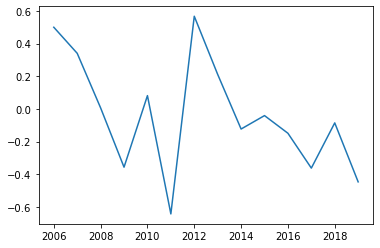

Spearman Correlation


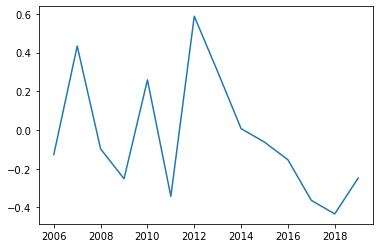

MSCI World Index % & Oil percent change
Pearsonr Correlation


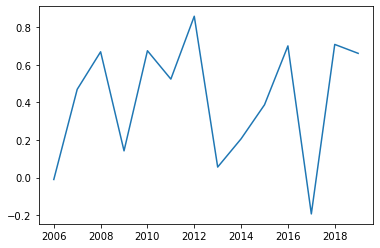

Spearman Correlation


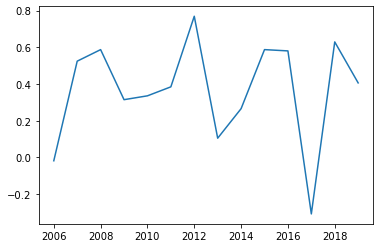

MSCI World Index % & VIX
Pearsonr Correlation


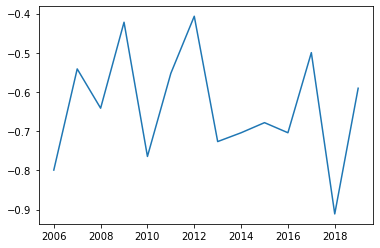

Spearman Correlation


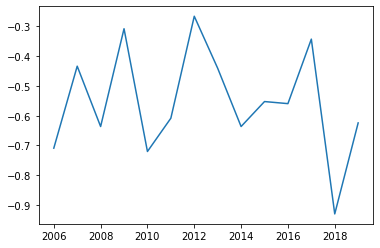

MSCI World Index % & Misery Index
Pearsonr Correlation


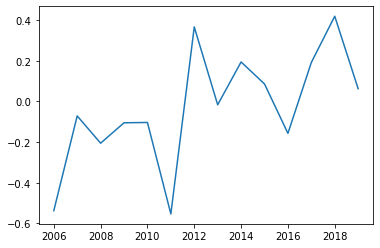

Spearman Correlation


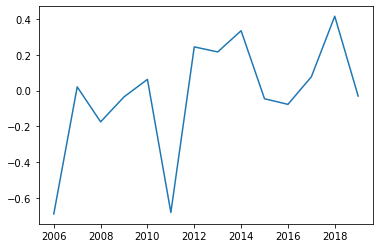

MSCI World Index % & T10Y2Y
Pearsonr Correlation


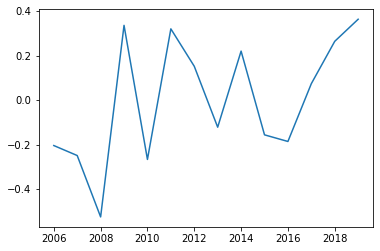

Spearman Correlation


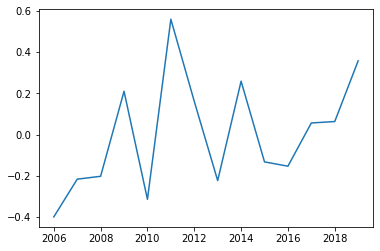

MSCI World Index % & corporate - rf
Pearsonr Correlation


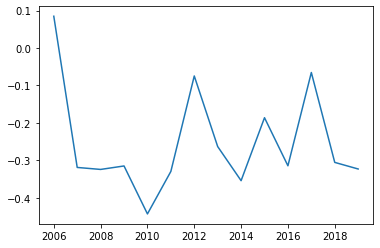

Spearman Correlation


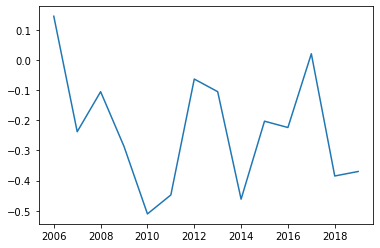

Goldman Commodity Index % & Gold percent change
Pearsonr Correlation


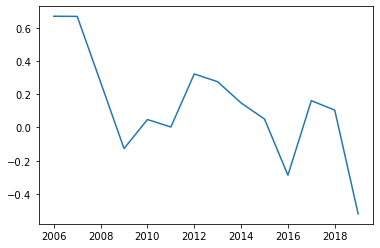

Spearman Correlation


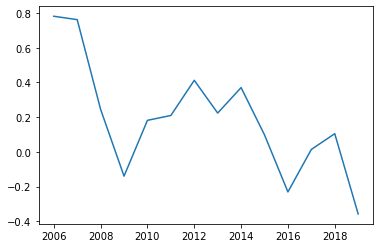

Goldman Commodity Index % & Oil percent change
Pearsonr Correlation


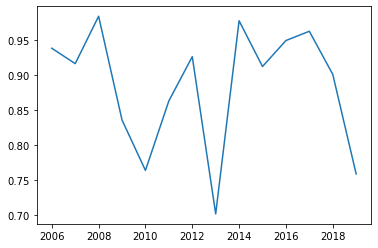

Spearman Correlation


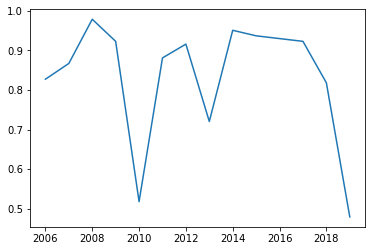

Goldman Commodity Index % & VIX
Pearsonr Correlation


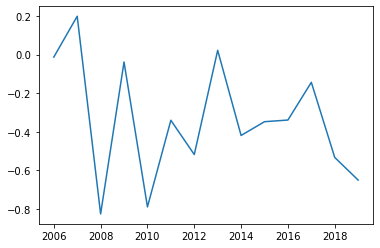

Spearman Correlation


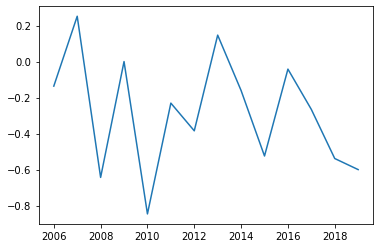

Goldman Commodity Index % & Misery Index
Pearsonr Correlation


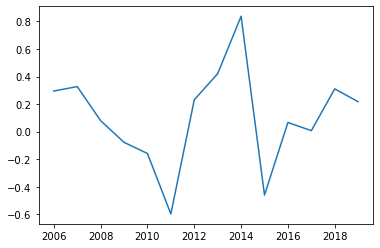

Spearman Correlation


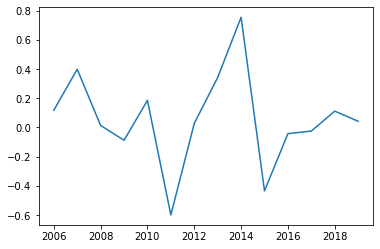

Goldman Commodity Index % & T10Y2Y
Pearsonr Correlation


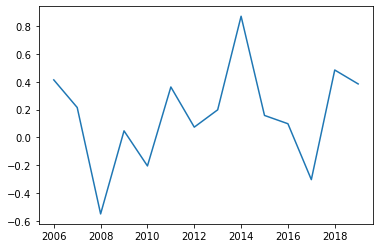

Spearman Correlation


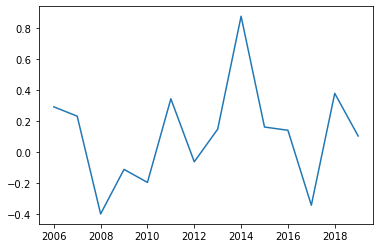

Goldman Commodity Index % & corporate - rf
Pearsonr Correlation


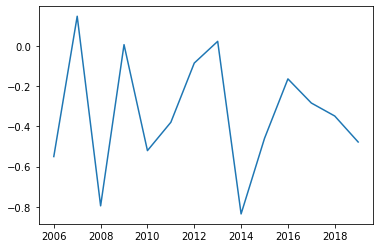

Spearman Correlation


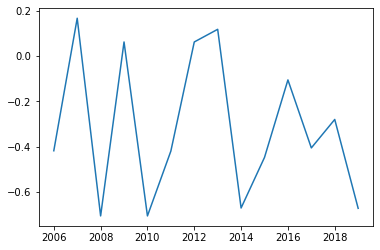

US 5Y Treasury Futures % & Gold percent change
Pearsonr Correlation


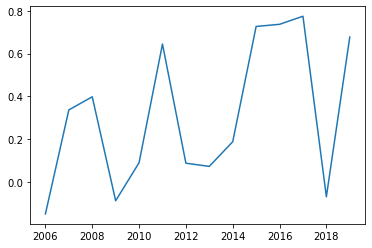

Spearman Correlation


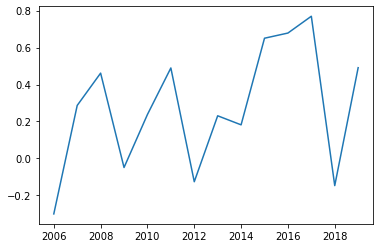

US 5Y Treasury Futures % & Oil percent change
Pearsonr Correlation


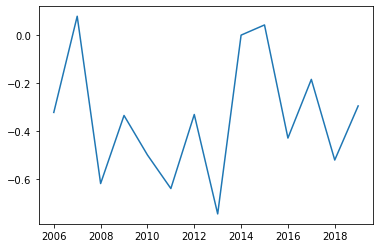

Spearman Correlation


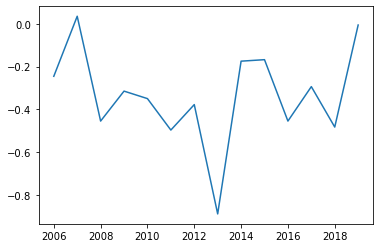

US 5Y Treasury Futures % & VIX
Pearsonr Correlation


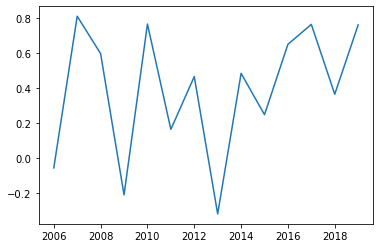

Spearman Correlation


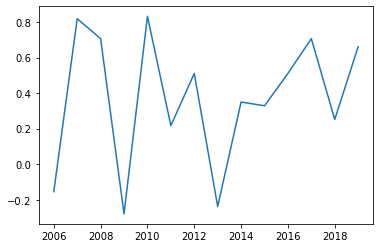

US 5Y Treasury Futures % & Misery Index
Pearsonr Correlation


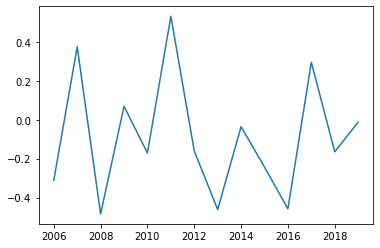

Spearman Correlation


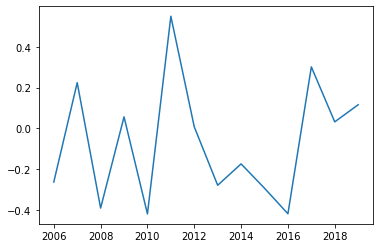

US 5Y Treasury Futures % & T10Y2Y
Pearsonr Correlation


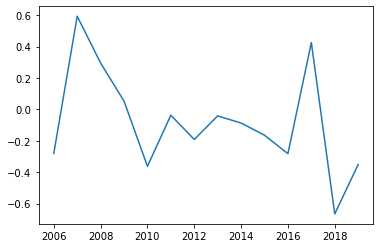

Spearman Correlation


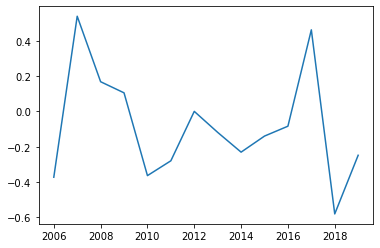

US 5Y Treasury Futures % & corporate - rf
Pearsonr Correlation


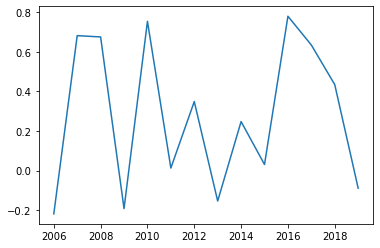

Spearman Correlation


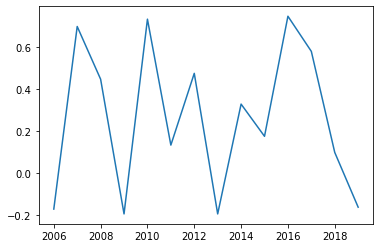

In [22]:
years = range(2006, 2020)
portfoilo = ['MSCI World Index %','Goldman Commodity Index %','US 5Y Treasury Futures %']
risk_indicator= ['Gold percent change','Oil percent change', 'VIX', 'Misery Index','T10Y2Y', 'corporate - rf']
           
for product in portfoilo:
    for risk in risk_indicator: 
        spearman_correlation_list = []
        pearsonr_correlation_list = []
        
        for single_year in years:
            resample_data_year = final_df[final_df.index.year == single_year].dropna().copy()
            resample_data_year.replace([np.inf, -np.inf], np.nan, inplace=True)
            resample_data_year = resample_data_year.dropna()
            
#             #Pearsonr - Check for linear relationship, same direction at constant rate
            pearsonr_data , _ = pearsonr(resample_data_year[product], resample_data_year[risk])
            pearsonr_correlation_list.append(pearsonr_data)
            
            #Spearman - Check for monotonic relationship, same direction different rate
            spearman_data , _ = spearmanr(resample_data_year[product], resample_data_year[risk])
            spearman_correlation_list.append(spearman_data)
                             
            #Chi-Square
#             table = [resample_data_year[product].values ** 2,
#                      resample_data_year[risk].values ** 2]
#             stat, p, dof, expected = chi2_contingency(table)
# #             print('dof=%d' % dof)
# #             print(expected)
#             # interpret test-statistic
#             prob = 0.95
#             critical = chi2.ppf(prob, dof)
#             print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
#             if abs(stat) >= critical:
#                 print('Dependent (reject H0)')
#             else:
#                 print('Independent (fail to reject H0)')
                
#         print(spearman_correlation_list)
#         print(pearsonr_correlation_list)
        
        print(product + ' & ' + risk)
        print('Pearsonr Correlation')
        plt.figure(0)
        plt.plot(years,pearsonr_correlation_list)
        plt.show()
        
        print('Spearman Correlation')
        plt.figure(1)
        plt.plot(years,spearman_correlation_list)
        plt.show()
        


# Regression`

In [47]:
#libraries for preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
le = preprocessing.LabelEncoder()

#libraries for evaluation
from sklearn.metrics import mean_squared_log_error,r2_score,mean_squared_error
from sklearn.model_selection import train_test_split

#libraries for models
from sklearn.linear_model import LinearRegression

from sklearn.linear_model import Ridge
from sklearn.linear_model import LassoCV,RidgeCV
from yellowbrick.regressor import AlphaSelection

from sklearn.linear_model import Lasso

from sklearn.neighbors import KNeighborsRegressor

from sklearn.ensemble import RandomForestRegressor

from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

from sklearn.ensemble import AdaBoostRegressor

import xgboost as xgb

In [31]:
final_df.columns

Index(['MSCI World Index %', 'Goldman Commodity Index %',
       'US 5Y Treasury Futures %', 'Gold percent change', 'VIX', 'T10Y2Y',
       'Misery Index', 'corporate - rf', 'Oil percent change',
       'Combination Return %', 'Combination Max Drawdown Prediction',
       'Combination Max Drawdown Monthly'],
      dtype='object')

In [154]:
ml_data = final_df
ml_data.replace([np.inf, -np.inf], np.nan, inplace=True)
ml_data = ml_data.dropna()

prediction = ['Combination Return %', 'Combination Max Drawdown Prediction',]
risk_indicator= ['Gold percent change', 'Oil percent change', 'VIX','Misery Index','T10Y2Y','corporate - rf']
             
feature_list_numerical =  ml_data[risk_indicator]
feature_list_target = ml_data[prediction[1]]

df = pd.concat([feature_list_numerical, feature_list_target], axis=1)
df

,Gold percent change,Oil percent change,VIX,Misery Index,T10Y2Y,corporate - rf,Combination Max Drawdown Prediction
Dates,,,,,,,
2006-02-28,0.006329,-0.058357,12.471053,8.40,-0.099474,-1.347895,-0.027712
2006-03-31,0.005305,0.021426,11.693913,8.06,-0.010000,-1.521739,-0.023687
2006-04-30,0.096059,0.116473,11.847368,8.25,0.101579,-1.835789,0.013460
2006-05-31,0.100783,0.003920,14.454545,8.77,0.141818,-1.980909,0.024528
2006-06-30,-0.115003,0.007176,16.918636,8.92,-0.015455,-1.874091,0.066829
...,...,...,...,...,...,...,...
2020-05-31,0.019149,0.671614,30.897000,13.42,0.503500,7.174500,0.675593
2020-08-31,0.066606,0.024266,22.889524,9.71,0.510476,4.993333,0.675593
2020-09-30,-0.023598,-0.065455,27.647619,9.27,0.544762,5.138571,0.675593


In [155]:
scaled_features = StandardScaler().fit_transform(df.values)
scaled_features_df = pd.DataFrame(scaled_features, index=df.index, columns=df.columns)
scaled_features_df

,Gold percent change,Oil percent change,VIX,Misery Index,T10Y2Y,corporate - rf,Combination Max Drawdown Prediction
Dates,,,,,,,
2006-02-28,-0.012235,-0.572152,-0.756872,0.083919,-1.602527,-1.527377,-2.139820
2006-03-31,-0.038290,0.184110,-0.841084,-0.067766,-1.500617,-1.574025,-2.121080
2006-04-30,2.270180,1.085071,-0.824456,0.016999,-1.373530,-1.658294,-1.948119
2006-05-31,2.390340,0.018173,-0.541936,0.248988,-1.327697,-1.697234,-1.896582
2006-06-30,-3.098536,0.049039,-0.274921,0.315908,-1.506830,-1.668571,-1.699627
...,...,...,...,...,...,...,...
2020-05-31,0.313855,6.347267,1.239809,2.323507,-0.915744,0.759438,1.134841
2020-08-31,1.521005,0.211028,0.372099,0.668354,-0.907798,0.174165,1.134841
2020-09-30,-0.773479,-0.639439,0.887698,0.472055,-0.868747,0.213137,1.134841


In [156]:
def trainingData(df,n):
    X = df.iloc[:,n]
    y = df.iloc[:,-1:].values.T
    y=y[0]
    X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=0.9,test_size=0.1,random_state=0)
    return (X_train,X_test,y_train,y_test)

X_train,X_test,y_train,y_test=trainingData(df,list(range(len(list(df.columns))-1)))

def result(y_test,y_pred):
    r=[]
    r.append(mean_squared_log_error(y_test, y_pred))
    r.append(np.sqrt(r[0]))
    r.append(r2_score(y_test,y_pred))
    r.append(round(r2_score(y_test,y_pred)*100,4))
    return (r)

#dataframe that store the performance of each model
accu=pd.DataFrame(index=['MSLE', 'Root MSLE', 'R2 Score','Accuracy(%)'])

## Model Implementation

1)Linear Regression

2)Ridge Regression

3)Lasso Regression

4)K-Neighbors Regressor

5)Random Forest Regressor

6)Bagging Regressor

7)Adaboost Regressor

8)XGBoost¶



# 1) Linear Regression

In [157]:
#fitting model
LR=LinearRegression()
LR.fit(X_train,y_train)
y_pred=LR.predict(X_test)

#calculating error/accuracy
y_test_1,y_pred_1=y_test,y_pred
r1_lr=result(y_test_1,y_pred_1)
print('Coefficients: \n', LR.coef_)
print("MSLE : {}".format(r1_lr[0]))
print("Root MSLE : {}".format(r1_lr[1]))
print("R2 Score : {} or {}%".format(r1_lr[2],r1_lr[3]))
accu['Linear Regression']=r1_lr

Coefficients: 
 [-0.77756778 -0.3448494  -0.00944036 -0.03468888 -0.05857098  0.02993818]
MSLE : 0.015044335487954447
Root MSLE : 0.12265535246353682
R2 Score : 0.36312926655283373 or 36.3129%


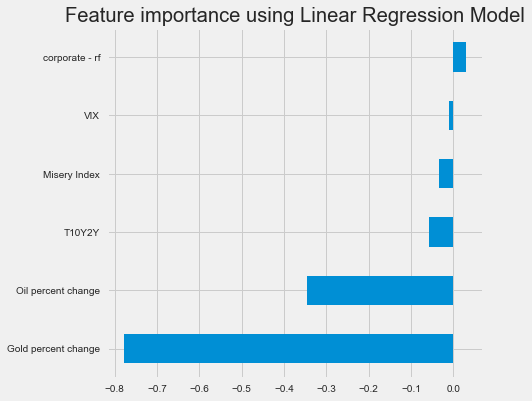

In [158]:
#Ploting feature importance graph
coef = pd.Series(LR.coef_, index = X_train.columns)
imp_coef = coef.sort_values()
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Linear Regression Model")
plt.savefig('Linear-Regression-Feature-Importance.jpg')
plt.show()

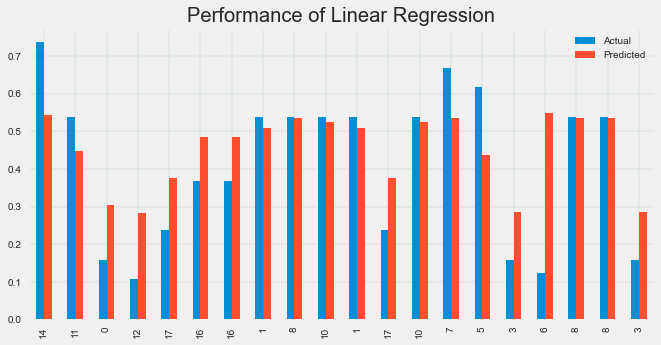

In [159]:
#Visualization of true value and predicted

df_check = pd.DataFrame({'Actual': y_test_1, 'Predicted': y_pred_1})
df_check = df_check.sample(20, replace=True)
df_check.plot(kind='bar',figsize=(10,5))
plt.grid(which='major', linestyle='-', linewidth='0.1', color='Green')
plt.title('Performance of Linear Regression')
plt.savefig('Linear-Regression-Performance')
plt.show()

# 2) Ridge regression

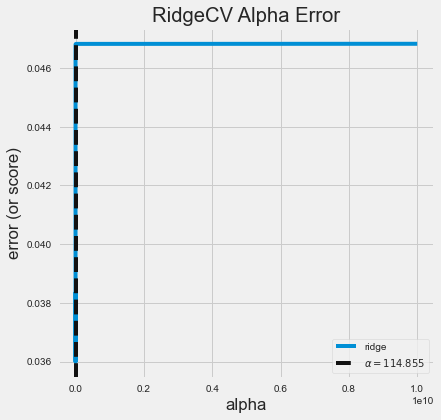

<AxesSubplot:title={'center':'RidgeCV Alpha Error'}, xlabel='alpha', ylabel='error (or score)'>

In [160]:
#predicting value of alpha

alphas = 10**np.linspace(10,-2,400)
model = RidgeCV(alphas=alphas)
visualizer = AlphaSelection(model)
visualizer.fit(X_train,y_train)
visualizer.show()

In [161]:
#model object and fitting model
RR=Ridge(alpha=20.336,solver='auto')
RR.fit(X_train,y_train)
y_pred=RR.predict(X_test)

In [162]:
#model evaluation

y_test_2,y_pred_2=y_test,y_pred
r2_ridge=result(y_test_2,y_pred_2)
print("MSLE : {}".format(r2_ridge[0]))
print("Root MSLE : {}".format(r2_ridge[1]))
print("R2 Score : {} or {}%".format(r2_ridge[2],r2_ridge[3]))
accu['Ridge Regression']=r2_ridge

MSLE : 0.013495843340301204
Root MSLE : 0.11617161159380206
R2 Score : 0.439954034181534 or 43.9954%


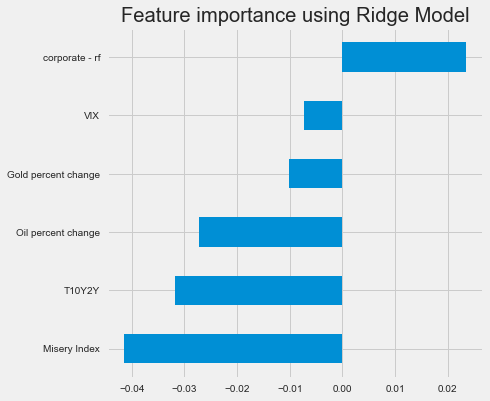

In [163]:
#Visualization of Feature Importance

coef = pd.Series(RR.coef_, index = X_train.columns)
imp_coef = coef.sort_values()
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Ridge Model")
plt.savefig('Ridge-Regression-Feature-Importance.jpg')
plt.show()

# 3) Lasso Regression

In [164]:
#model object and fitting it
lasso=Lasso(alpha=0.0001)
lasso.fit(X_train,y_train)
y_pred=lasso.predict(X_test)

In [165]:
#model evaluation
y_test_3,y_pred_3=y_test,y_pred
r3_lasso=result(y_test_3,y_pred_3)
print("MSLE : {}".format(r3_lasso[0]))
print("Root MSLE : {}".format(r3_lasso[1]))
print("R2 Score : {} or {}%".format(r3_lasso[2],r3_lasso[3]))
accu['Lasso Regression']=r3_lasso

MSLE : 0.014961649978777322
Root MSLE : 0.12231782363489518
R2 Score : 0.36770141094465647 or 36.7701%


# 4) KNN

In [166]:
#estimating MSLE for k=1-9
R_MSLE=[]
for i in range(1,10):
    KNN=KNeighborsRegressor(n_neighbors=i)
    KNN.fit(X_train,y_train)
    y_pred=KNN.predict(X_test)
    error=np.sqrt(mean_squared_log_error(y_test, y_pred))
    R_MSLE.append(error)
    print("K =",i," , Root MSLE =",error)

K = 1  , Root MSLE = 0.08965492009548923
K = 2  , Root MSLE = 0.057996972605945094
K = 3  , Root MSLE = 0.06169471580825945
K = 4  , Root MSLE = 0.05786740056752834
K = 5  , Root MSLE = 0.05345324909423422
K = 6  , Root MSLE = 0.0550947724718001
K = 7  , Root MSLE = 0.059309321089493466
K = 8  , Root MSLE = 0.06001029668979483
K = 9  , Root MSLE = 0.06145821340818982


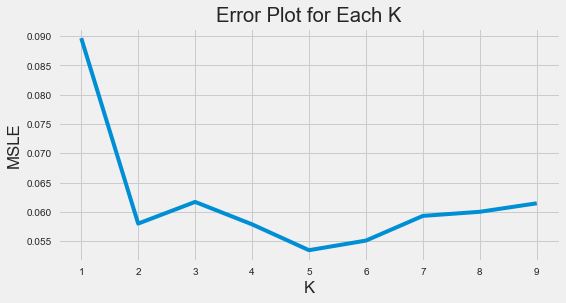

In [167]:
#plotting error
curve = pd.DataFrame(R_MSLE) #elbow curve 
plt.figure(figsize=(8,4))
plt.xticks(list(range(1,10)), list(range(1,10)), rotation='horizontal')
plt.plot(list(range(1,10)),R_MSLE)
plt.xlabel('K')
plt.ylabel('MSLE')
plt.title('Error Plot for Each K')
plt.savefig('KNN-Error-Plot.jpg')
plt.show()

In [168]:
#model implementation
KNN=KNeighborsRegressor(n_neighbors=5) 
KNN.fit(X_train,y_train)
y_pred=KNN.predict(X_test)

In [169]:
#model evaluation
r4_knn=result(y_test,y_pred)
print("MSLE : {}".format(r4_knn[0]))
print("Root MSLE : {}".format(r4_knn[1]))
print("R2 Score : {} or {}%".format(r4_knn[2],r4_knn[3]))
accu['KNN']=r4_knn

MSLE : 0.002857249838730251
Root MSLE : 0.05345324909423422
R2 Score : 0.8891753008593553 or 88.9175%


In [170]:
accu.to_csv('errors.csv')

# 5) Random Forest

In [171]:
RFR = RandomForestRegressor(n_estimators=180,random_state=0, min_samples_leaf=1, max_features=0.5, n_jobs=-1, oob_score=True)
RFR.fit(X_train,y_train)
y_pred = RFR.predict(X_test)

In [172]:
r5_rf=result(y_test,y_pred)
print("MSLE : {}".format(r5_rf[0]))
print("Root MSLE : {}".format(r5_rf[1]))
print("R2 Score : {} or {}%".format(r5_rf[2],r5_rf[3]))
accu['RandomForest Regressor']=r5_rf

MSLE : 0.002592947783916298
Root MSLE : 0.050920995511834787
R2 Score : 0.8950294961770753 or 89.5029%


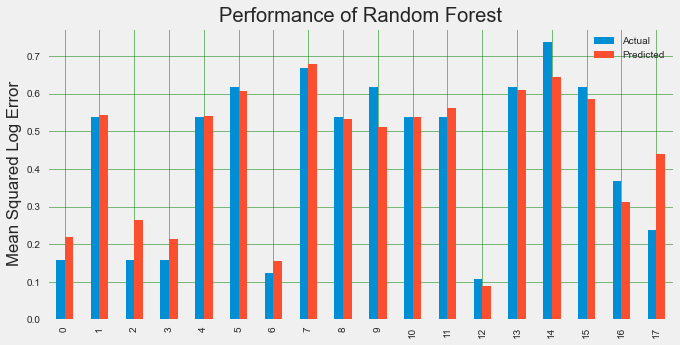

In [173]:
df_check = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_check = df_check.head(25)
#round(df_check,2)
df_check.plot(kind='bar',figsize=(10,5))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.title('Performance of Random Forest')
plt.ylabel('Mean Squared Log Error')
plt.savefig('Random-Forest-Performance.jpg')
plt.show()

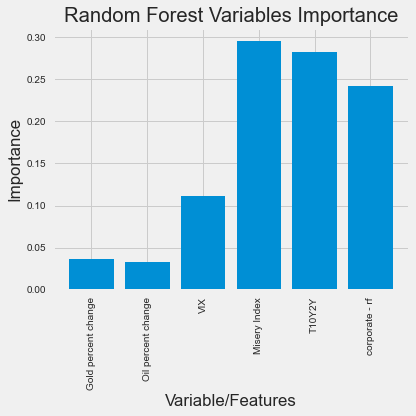

In [174]:
importances=RFR.feature_importances_
features=X_train.columns

# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.figure(figsize=(6,6))
plt.bar(x_values, importances, orientation = ('vertical'))
# Tick labels for x axis
plt.xticks(x_values, features, rotation=(90))
# Axis labels and title
plt.ylabel('Importance'); 
plt.xlabel('Variable/Features'); 
plt.title('Random Forest Variables Importance')
plt.tight_layout()
plt.savefig('Random-Forest-Variables-Importances.jpg',dpi=600)
plt.show();

# 6) Bagging Regressor

In [175]:
#model implementation
baggReg=BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=20),n_estimators=50, random_state=1,
                         max_samples=1.0, max_features=1.0, bootstrap=False, 
                         bootstrap_features=False, oob_score=False, warm_start=False, n_jobs=-1, verbose=0)
baggReg.fit(X_train,y_train)
y_pred=baggReg.predict(X_test)

In [176]:
#model evaluation
r6_br=result(y_test,y_pred)
print("MSLE : {}".format(r6_br[0]))
print("Root MSLE : {}".format(r6_br[1]))
print("R2 Score : {} or {}%".format(r6_br[2],r6_br[3]))

MSLE : 0.015062597332336364
Root MSLE : 0.12272977361804414
R2 Score : 0.4075491349635575 or 40.7549%


In [177]:
accu['Bagging Regressor']=r6_br
accu.to_csv('errors.csv')

# 7) Adaboost

In [178]:
#model implementation
ABR = AdaBoostRegressor(
    DecisionTreeRegressor(max_depth=24),
    n_estimators=200,learning_rate=0.6
)

ABR.fit(X_train, y_train)
y_pred = ABR.predict(X_test)

In [179]:
#model evaluation
r7_ab=result(y_test,y_pred)
print("MSLE : {}".format(r7_ab[0]))
print("Root MSLE : {}".format(r7_ab[1]))
print("R2 Score : {} or {}%".format(r7_ab[2],r7_ab[3]))

MSLE : 0.0007738513090026528
Root MSLE : 0.02781818306436732
R2 Score : 0.9723478373528838 or 97.2348%


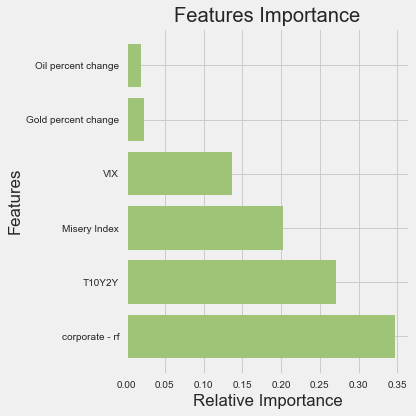

In [180]:
importances=ABR.feature_importances_
features=X_train.columns

indices = np.argsort(importances)
indices = [x for x in reversed(indices)]
plt.figure(1)
plt.title('Features Importance')
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.savefig('Adaboost-Features-Importance2.jpg',dpi=60)
plt.show();

In [181]:
accu['AdaBoost Regressor']=r7_ab
accu.to_csv('errors.csv')

# 8) XGboost

In [182]:
#model implementation and fitting data
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', learning_rate = 0.4,
                max_depth = 24, alpha = 5, n_estimators = 200)
xg_reg.fit(X_train,y_train)
y_pred = xg_reg.predict(X_test)

y_test_1,y_pred_1=y_test,y_pred
r8_xg=result(y_test_1,y_pred_1)
print("MSLE : {}".format(r8_xg[0]))
print("Root MSLE : {}".format(r8_xg[1]))
print("R2 Score : {} or {}%".format(r8_xg[2],r8_xg[3]))

MSLE : 0.01822058707014896
Root MSLE : 0.13498365482586755
R2 Score : 0.25174966353139583 or 25.175%


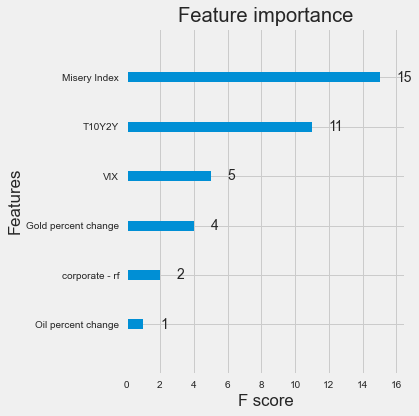

In [183]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.tight_layout()
plt.savefig('XGBoost-Features-Importance.jpg')
plt.show();

# Overall Result

In [184]:
accu=pd.read_csv('./errors.csv',index_col=0)
accu

,Linear Regression,Ridge Regression,Lasso Regression,KNN,RandomForest Regressor,Bagging Regressor,AdaBoost Regressor
MSLE,0.015044,0.013496,0.014962,0.002857,0.002593,0.015063,0.000774
Root MSLE,0.122655,0.116172,0.122318,0.053453,0.050921,0.122730,0.027818
R2 Score,0.363129,0.439954,0.367701,0.889175,0.895029,0.407549,0.972348
Accuracy(%),36.312900,43.995400,36.770100,88.917500,89.502900,40.754900,97.234800


In [185]:
model_accuracy=accu.loc['Accuracy(%)']

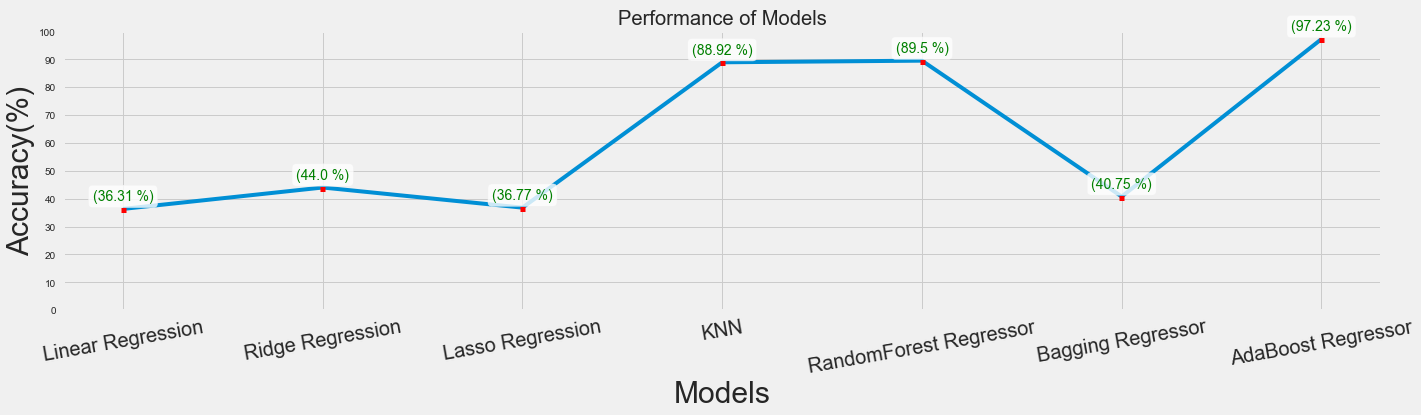

In [186]:
x=list(range(len(model_accuracy)))
y=list(range(0,101,10))
props = dict(boxstyle='round', facecolor='white', alpha=0.8)
plt.figure(figsize=(20,6))
plt.plot(model_accuracy)
plt.yticks(y)
plt.xticks(fontsize=20)
plt.xticks(rotation = (10))
plt.xlabel("Models",fontsize=30)
plt.ylabel("Accuracy(%)",fontsize=30)
plt.title("Performance of Models")
for a,b in zip(x,y):
    b=model_accuracy[a]
    val="("+str(round(model_accuracy[a],2))+" %)"
    plt.text(a, b+4.5, val,horizontalalignment='center',verticalalignment='center',color='green',bbox=props)
    plt.text(a, b+3.5, '.',horizontalalignment='center',verticalalignment='center',color='red',fontsize=50)
plt.tight_layout()
plt.savefig('Overall-Performance.jpg',dpi=600)
plt.show();

# 4) Making Prediction Based On Existing Data

In [187]:
ml_data = final_df.iloc[23:24]

prediction = ['Combination Return %', 'Combination Max Drawdown Prediction',]
risk_indicator= ['Gold percent change', 'Oil percent change', 'VIX','Misery Index','T10Y2Y','corporate - rf']
             
feature_list_numerical =  ml_data[risk_indicator]
feature_list_target = ml_data[prediction[1]]

df = pd.concat([feature_list_numerical, feature_list_target], axis=1)
df

,Gold percent change,Oil percent change,VIX,Misery Index,T10Y2Y,corporate - rf,Combination Max Drawdown Prediction
Dates,,,,,,,
2007-12-31,0.000521,-0.012936,21.651,9.08,0.9805,2.4315,0.289558


In [188]:
y_pred = ABR.predict(df.iloc[:,list(range(len(list(df.columns))-1))])
y_pred

array([0.28955757])